In [1]:
import sys
sys.path.append('C:\\Program Files\\ASAP 2.2\\bin')

import multiresolutionimageinterface as mir
import cv2
from tqdm import tqdm_notebook
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
# 한 슬라이드 이미지의 tissue mask, tumor mask 결과를 시각화하기 위한 코드 파일
imagePath = '../data/training/center_0/patient_004_node_4.tif'
maskPath = imagePath.replace('.tif', '_mask.tif')

# Pixel coordinates

# patient_004_node_4의 해당 coordinates에 tumor 존재.
x_center = 12711
y_center = 88778

# tumor 없는 coordinates
#x_center = 12711
#y_center = 88578

# Fixed crop size
width = 256
height = 256

# Visualization scale for plotting
scale = 50
# Sample these levels, decreasing order
downsamples = [16,8,4,2,1]

# patient_004_node_4.tif파일과 그 mask 파일 read
reader = mir.MultiResolutionImageReader()
mr_image = reader.open(imagePath)
mr_mask = reader.open(maskPath)

In [3]:
# x, y center값들을 매개변수로 받아 이미지와 마스크 샘플 가져오는 함수
def getSamplesWithAnnotations(x_cent, y_cent):
    channels = 3
    imgs = np.zeros((len(downsamples), width, height, channels), dtype=np.int32)
    masks = np.zeros((len(downsamples), width, height, channels), dtype=np.int32)
    for i, ds_size in enumerate(downsamples): # downsample은 16, 8, 4, 2, 1 순서로 진행
        lev = mr_image.getBestLevelForDownSample(ds_size)
        ds = mr_image.getLevelDownsample(lev)

        # 슬라이드 이미지
        imgs[i] = mr_image.getUCharPatch(int(x_cent - (ds*width/2)),
                                         int(y_cent - (ds*height/2)),
                                         width,
                                         height,
                                         lev)
        # tumor 마스크
        masks[i] = mr_mask.getUCharPatch(int(x_cent - (ds*width/2)),
                                         int(y_cent - (ds*height/2)),
                                         width,
                                         height,
                                         lev)
    return imgs, masks # 각 다운샘플에 대한 이미지, 마스크

In [8]:
# level 0의 mask에서 0보다 큰 값이 있다면 종양으로 라벨링하는 함수
def isTumor(mask_level_0):
    return (mask_level_0.max() > 0)

# level 0의 mask에서 1(종양인 부분)의 비율로 percentage of tumor를 계산하는 함수
def tumorPercentage(mask_level_0):
    area = mask_level_0.shape[0] * mask_level_0.shape[1]
    tumorPixels = 0
    channels = 3
    for p in mask_level_0.flatten():
        tumorPixels = tumorPixels + 1 if p == 1 else tumorPixels
    return tumorPixels / (area * channels)

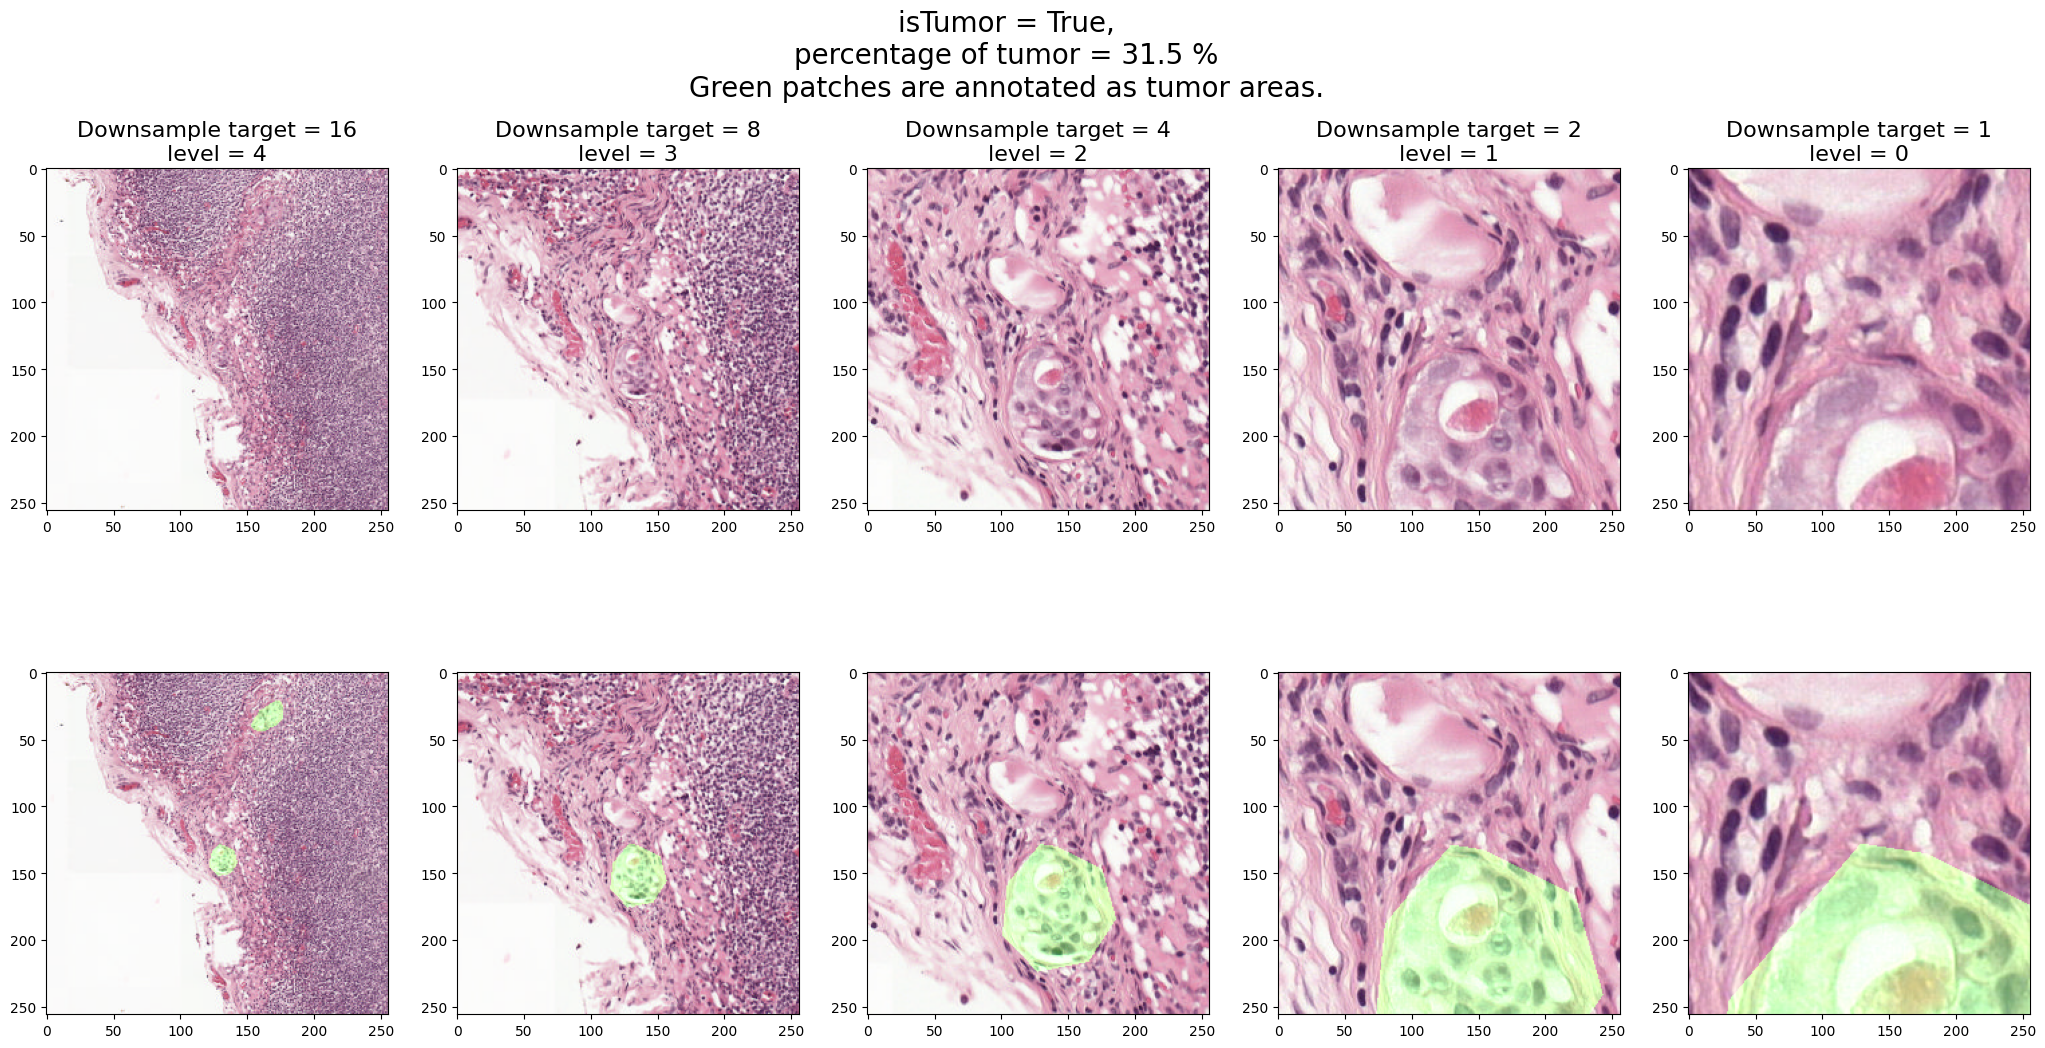

In [9]:
f, ax = plt.subplots(2,len(downsamples),figsize = (len(downsamples) * width / scale, int(2.5 * height / scale)))

imgs, masks = getSamplesWithAnnotations(x_cent=x_center,
                                        y_cent=y_center)
# 가장 낮은 level(downsample)의 레이블 확인
lbl = isTumor(masks[len(downsamples) - 1])
tumorPrc = tumorPercentage(masks[len(downsamples) - 1])
f.suptitle('isTumor = {0},\npercentage of tumor = {1} %\nGreen patches are annotated as tumor areas.'.format(lbl, int(tumorPrc * 1000)/10), fontsize=20)
alpha = 0.5

for i, ds_size in enumerate(downsamples):
    level = mr_image.getBestLevelForDownSample(ds_size)
    ax[0,i].imshow(imgs[i])
    
    # 마스크 색을 초록으로 설정
    mask_color = masks[i] * 200
    mask_color[:,:,[0,2]] = 0
    
    # 마스크에 투명도 채널 추가
    alpha_c = np.ones((mask_color.shape[0], mask_color.shape[1], 1), dtype=np.int32) * 255
    mask_color = np.concatenate([mask_color, alpha_c], axis=2)
    alpha_image = np.concatenate([imgs[i], alpha_c], axis=2)
    
    for x in range(mask_color.shape[0]):
        for y in range(mask_color.shape[1]):
            mask_color[x, y, 3] = 255 if mask_color[x, y, 2] == 1 else 0
            
    alpha_image = cv2.addWeighted(mask_color, 0.5, alpha_image, 1, 0)
    alpha_image = alpha_image.clip(min=0,max=255)
    ax[1,i].imshow(alpha_image)
    ax[0,i].set_title('Downsample target = {0}\nlevel = {1}'.format(ds_size, level), fontsize=16)

In [3]:
## This function is adapted from a digital pathology pipeline code of Mikko Tukiainen
# utils 폴더의 wsi2tissueMask.py 파일의 함수들과 동일.
# 배경은 0으로, 조직부분은 255로 저장
def make_tissue_mask(slide, mask_level = 4, morpho=None, morpho_kernel_size=5, morpho_iter=1, median_filter=False, return_original = False): 
    ''' make tissue mask
        return tissue mask array which has tissue locations (pixel value 0 -> empty, 255 -> tissue)
    Args:
        slide (MultiResolutionImage): MultiResolutionImage slide to process
        mask_level (int): defines the level of zoom at which the mask be created (default 4)
        morpho (cv2.MORPHO): OpenCV morpho flag, Cv2.MORPHO_OPEN or Cv2.MORPHO_CLOSE (default None)
        morpho_kernel_size (int): kernel size for morphological transformation (default 5)
        morpho_iter (int): morphological transformation iterations (default=1)
        median_filtern (bool): Use median filtering to remove noise (default False)
        return_original (bool): return also the unmasked image
    '''
    
    # 슬라이드 읽기
    ds = slide.getLevelDownsample(mask_level)
    original_tissue = slide.getUCharPatch(0,
                                         0,
                                         int(slide.getDimensions()[0] / float(ds)),
                                         int(slide.getDimensions()[1] / float(ds)),
                                         mask_level)
    
    # 마스크의 밝기 채널만 추출하여 threshold에 따라 이진화
    tissue_mask = cv2.cvtColor(np.array(original_tissue), cv2.COLOR_RGBA2RGB)
    tissue_mask = cv2.cvtColor(tissue_mask, cv2.COLOR_BGR2HSV)
    tissue_mask = tissue_mask[:, :, 1]
    _, tissue_mask = cv2.threshold(tissue_mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # morphology 변환
    if morpho is not None:
        kernel = np.ones((morpho_kernel_size,morpho_kernel_size), np.uint8)
        tissue_mask = cv2.morphologyEx(tissue_mask, morpho, kernel, iterations = morpho_iter)
    
    # 중앙값 필터링으로 노이즈 제거
    if median_filter:
        tissue_mask = cv2.medianBlur(tissue_mask, 15)
    
    # 마스크를 넘파이 배열로 변환
    tissue_mask = np.array(tissue_mask, dtype=np.uint8)

    # 원본도 같이 저장할지
    if return_original:
        return tissue_mask, original_tissue
    else:
        return tissue_mask

In [13]:
# 샘플(패치) 중심위치 생성 함수
def sample_centers(tissue_mask, mask_downscale=16, sample_side=256, focus_width_percentage=0.25, padding_percentage=0.01):
    # 조직 마스크의 가로 ,세로
    mask_width, mask_height = tissue_mask.shape[:2]

    # 샘플 사이즈
    side = sample_side / mask_downscale

    # 패딩 크기
    padding_width = mask_width*padding_percentage
    padding_height = mask_height*padding_percentage

    # 포커스 영역의 반 너비
    half_focus = int(sample_side*focus_width_percentage / mask_downscale)
    
    # 샘플 중심 좌표를 저장할 리스트
    sample_centers = []
    
    # 조직이 존재하는 영역 기반으로 샘플 중심을 결정
    for i in range(int(mask_width // side)):
        for j in range(int(mask_height // side)):
            for sub_shift in [0, 0.5]:
                x = int((i+sub_shift) * side)
                y = int((j+sub_shift) * side)
                min_x = int(max(0, x - half_focus))
                max_x = int(min(x + half_focus, mask_width - 1))
                min_y = int(max(0, y - half_focus))
                max_y = int(min(y + half_focus, mask_height - 1))
                
                # 패딩 영역의 샘플은 건너뜀
                if(min_x < padding_width or max_x > mask_width-padding_width): continue
                if(min_y < padding_height or max_y > mask_height-padding_height): continue
                
                # 조직이 존재하는 영역만 샘플로 추가
                if(tissue_mask[min_x:max_x, min_y:max_y].sum() > 0):
                    sample_centers.append(np.array([x, y]))
                    
    # 마스크 다운스케일을 복원하여 좌표 계산
    sample_centers = np.array(sample_centers) * mask_downscale
    return sample_centers

In [14]:
comparison_masks = []
comparison_mask_titles = []

otsu_mask, original_image = make_tissue_mask(mr_image, 
                                             mr_image.getBestLevelForDownSample(16), 
                                             return_original=True)

# replace black "empty" areas with white for cleaner visualization
#original_image[np.where((original_image < [18,18,18]).all(axis = 2))] = [252,252,252]    

comparison_mask_titles.append('Original tissue')
comparison_masks.append(original_image)
comparison_mask_titles.append('Otsu mask')
comparison_masks.append(otsu_mask)

comparison_mask_titles.append('Otsu mask\nMorphological closing (iter=1)')
comparison_masks.append(make_tissue_mask(mr_image, 
                                         mr_image.getBestLevelForDownSample(16), 
                                         morpho=cv2.MORPH_CLOSE,
                                         morpho_kernel_size=7,
                                         morpho_iter=1))

comparison_mask_titles.append('Otsu mask\nMorphological closing (iter=2)')
comparison_masks.append(make_tissue_mask(mr_image, 
                                         mr_image.getBestLevelForDownSample(16), 
                                         morpho=cv2.MORPH_CLOSE,
                                         morpho_kernel_size=7,
                                         morpho_iter=2))

comparison_mask_titles.append('Otsu mask\nMorphological closing (iter=2)\nMedian filter')
comparison_masks.append(make_tissue_mask(mr_image,
                                         mr_image.getBestLevelForDownSample(16), 
                                         morpho=cv2.MORPH_CLOSE,
                                         morpho_kernel_size=7,
                                         morpho_iter=2,
                                         median_filter=True))

<timed exec>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


CPU times: total: 1.19 s
Wall time: 3.94 s


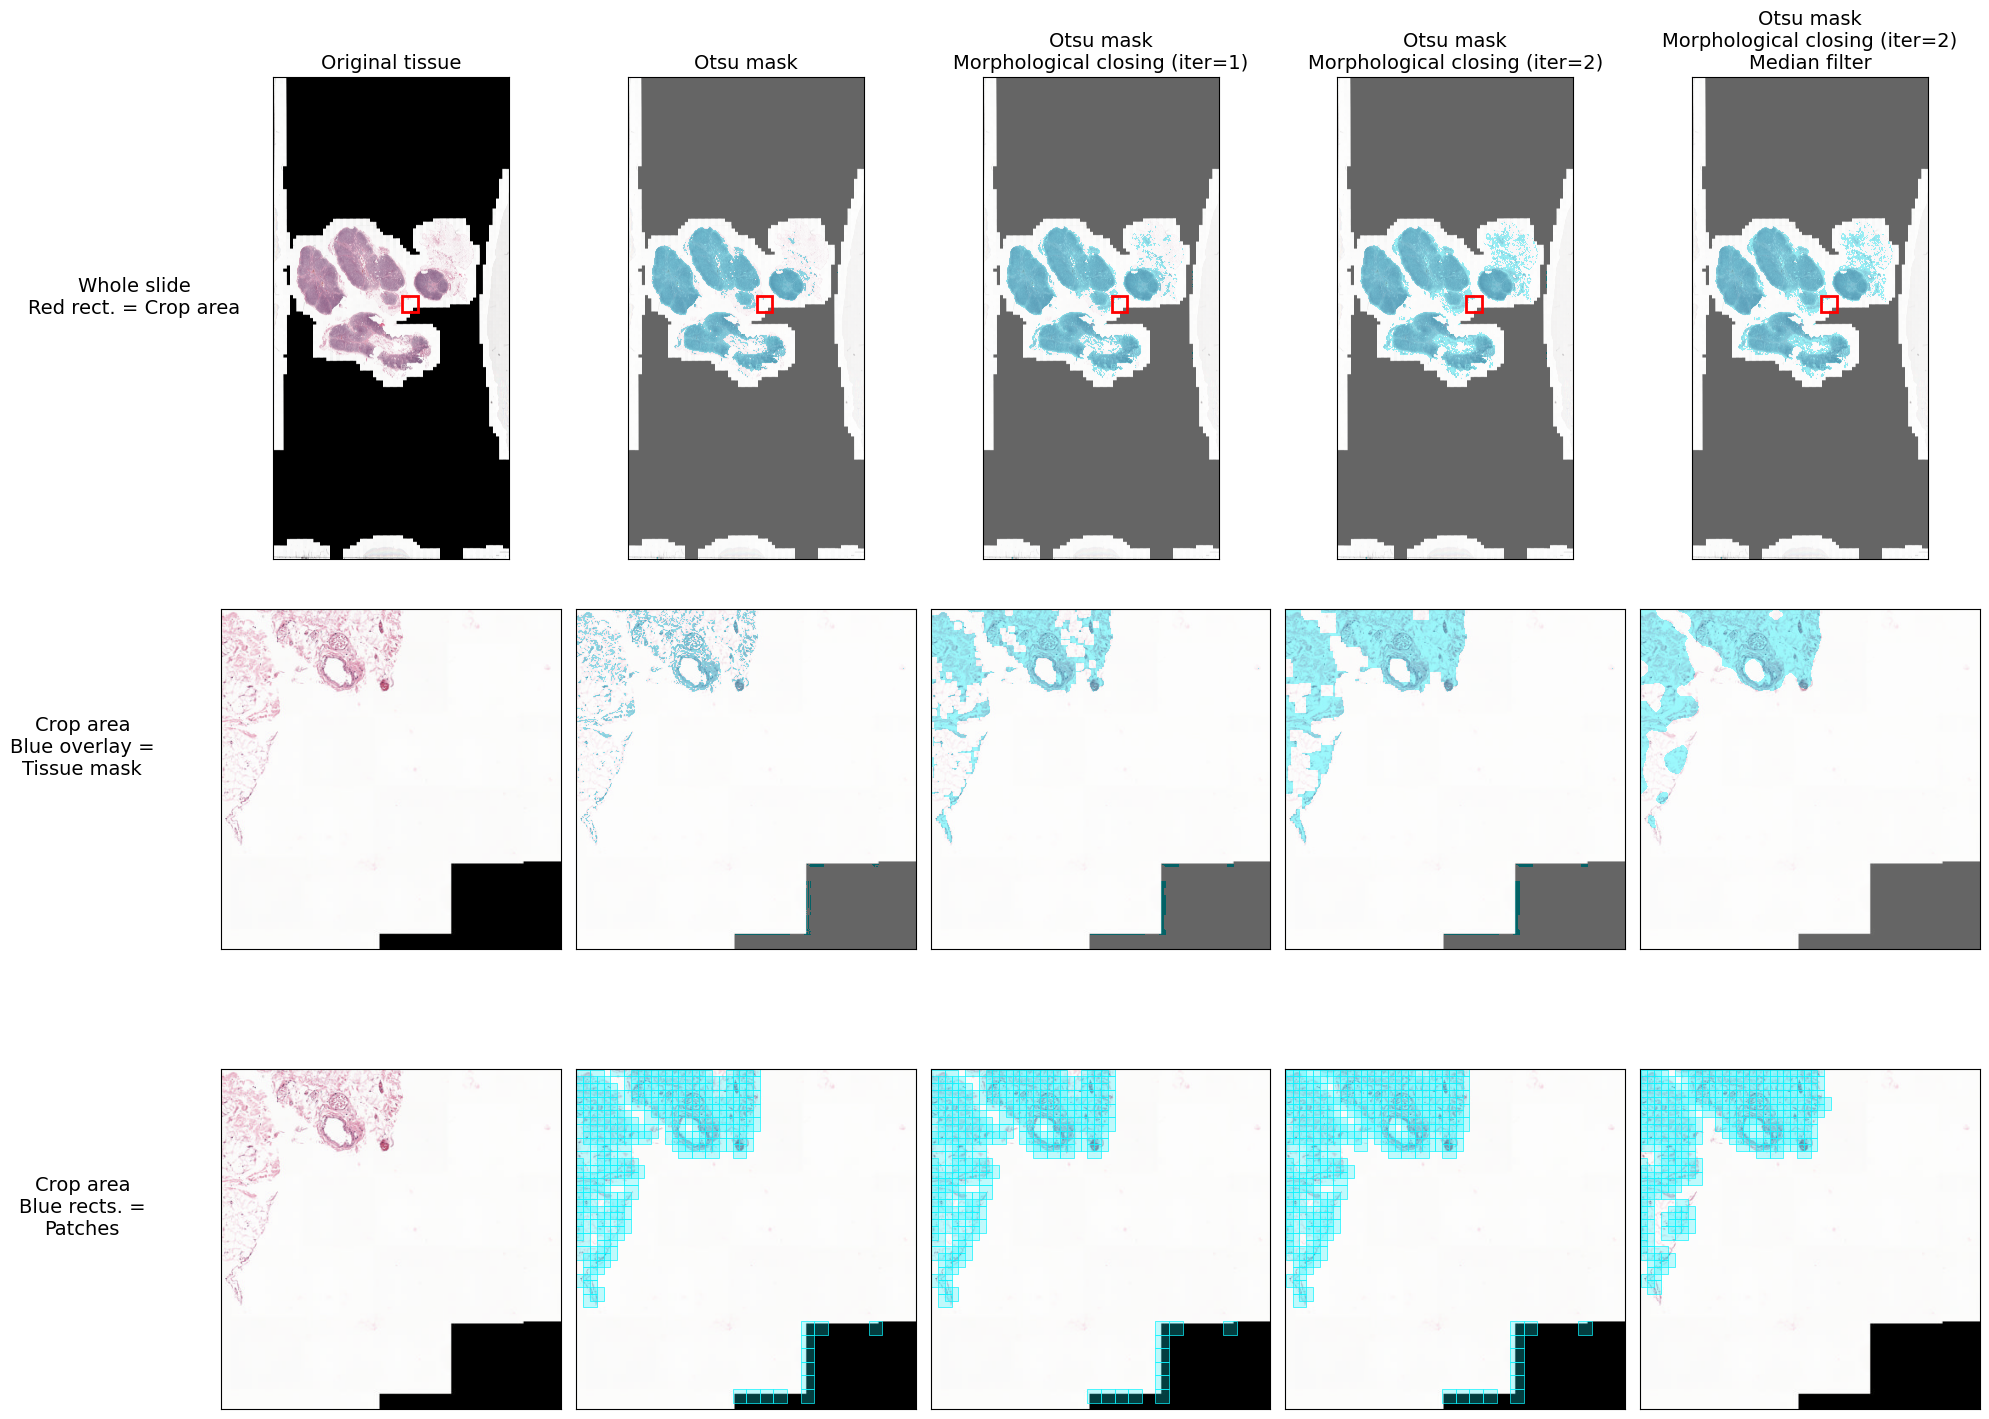

In [15]:
%%time
import matplotlib.patches as patches

# colormap for mask
from matplotlib import cm
from matplotlib.colors import ListedColormap
blues = cm.get_cmap('Blues', 256)
lightblue = blues(np.linspace(0, 1, 256))
lightblue[:100] = np.array([256/256,256/256,256/256,1])
turquoise = np.array([13/256,244/255,256/256,1])
turquoise_transparent = np.array([13/256,244/255,256/256,0.25])
lightblue[100:] = turquoise

f, ax = plt.subplots(3,len(comparison_masks),figsize=(20,15))
crop_x1 = 3300
crop_x2 = 3700
crop_y1 = 5600
crop_y2 = 6000
level_0_size = 256 / 16
fontsize_sz = 14
cmp = ListedColormap(lightblue)
alphaTissue = 1
alphaMask = 0.4

ax[0,0].imshow(comparison_masks[0], cmap=cmp)
ax[1,0].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp)
ax[2,0].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp)

for i in range(len(comparison_masks)):
    # draw first row
    if (i != 0):
        ax[0,i].imshow(comparison_masks[0], cmap=cmp, alpha=alphaTissue)
        ax[0,i].imshow(comparison_masks[i], cmap=cmp, alpha=alphaMask)
    ax[0,i].set_title(comparison_mask_titles[i], fontsize=fontsize_sz)
    crop_rect = patches.Rectangle((crop_x1,
                                   crop_y1),
                                  crop_x2-crop_x1,
                                  crop_y2-crop_y1,
                                  linewidth=2,
                                  edgecolor='r',
                                  facecolor='none')
    ax[0,i].add_patch(crop_rect)
    
    # draw second row
    if (i != 0):
        ax[1,i].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=alphaTissue)
        ax[1,i].imshow(comparison_masks[i][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=alphaMask)
    
    # draw third row
    if (i != 0):
        sample_c_pts = sample_centers(comparison_masks[i][crop_y1:crop_y2, crop_x1:crop_x2],
                                      mask_downscale=1,
                                      sample_side=level_0_size,
                                      padding_percentage=0)
        ax[2,i].imshow(comparison_masks[0][crop_y1:crop_y2, crop_x1:crop_x2], cmap=cmp, alpha=1)
        for pt in sample_c_pts:
            window_rect = patches.Rectangle((pt[1] - (level_0_size)/2,
                                             pt[0] - (level_0_size)/2),
                                            level_0_size,
                                            level_0_size,
                                            linewidth=0.5,
                                            edgecolor=turquoise,
                                            facecolor=turquoise_transparent)
            ax[2,i].add_patch(window_rect)
    
    # hide ticks
    for j in range(3):
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
        
ax[0,0].set_ylabel('Whole slide\nRed rect. = Crop area', fontsize=fontsize_sz, rotation=0, labelpad=100)
ax[1,0].set_ylabel('Crop area\nBlue overlay =\nTissue mask', fontsize=fontsize_sz, rotation=0, labelpad=100)
ax[2,0].set_ylabel('Crop area\nBlue rects. =\nPatches', fontsize=fontsize_sz, rotation=0, labelpad=100)
plt.tight_layout()

CPU times: total: 3.19 s
Wall time: 18.9 s


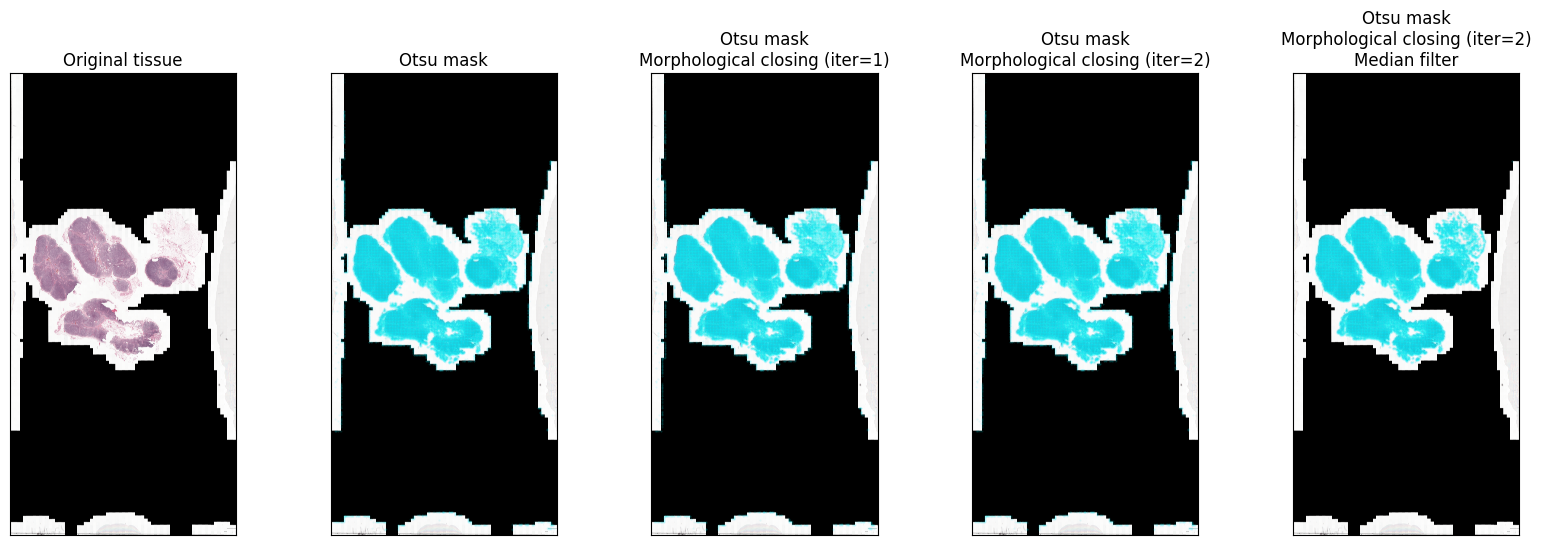

In [16]:
%%time
fontsize_sz = 12
f, ax = plt.subplots(1,len(comparison_masks),figsize=(20,6))
for i in range(len(comparison_masks)):
    ax[i].imshow(comparison_masks[0], cmap=cmp)
    ax[i].set_title(comparison_mask_titles[i], fontsize=fontsize_sz)
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    if (i>0):
        sample_c_pts = sample_centers(comparison_masks[i],
                                              mask_downscale=1,
                                              sample_side=level_0_size)

        ax[i].scatter(sample_c_pts[:,1], sample_c_pts[:,0], s=0.2, color=turquoise_transparent, alpha=0.1)

In [4]:
dirData = '../data/training/'
ImageFiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(dirData):
    for file in f:
        if '.tif' in file and 'mask' not in file:
            ImageFiles.append(os.path.join(r, file))

In [5]:
def CreateTissueMask(tifPath):
    
    # get only the name without dir or file suffix
    fileNamePart = tifPath.replace('.tif','').replace(dirData, "")
    
    # Skip if this mask is already found
    maskPath = tifPath.replace('.tif', '_tissue_mask_ds16.npy')
    if (os.path.isfile(maskPath)):
        print('Info - Tissue mask file of {0} already exists - skipping'.format(tifPath))
        return
    
    # create tissue mask
    mr_image = reader.open(tifPath)
    if(mr_image is None):
        print('Warning - Could not read {0} - skipping'.format(tifPath))
        return
    tissue_mask = make_tissue_mask(mr_image,
                                   mr_image.getBestLevelForDownSample(16), 
                                   morpho=cv2.MORPH_CLOSE,
                                   morpho_kernel_size=7,
                                   morpho_iter=2,
                                   median_filter=True)
    # tissue_mask is a binary array dtype.uint8  (16 times downsampled)
    np.save(maskPath, tissue_mask)

In [6]:
for f in tqdm_notebook(ImageFiles, 'Creating tissue masks...'):
    print('WSI: ' + f)
    CreateTissueMask(f)

C:\Users\songhow53\AppData\Local\Temp\ipykernel_13140\1165693191.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm_notebook(ImageFiles, 'Creating tissue masks...'):


Creating tissue masks...:   0%|          | 0/6 [00:00<?, ?it/s]

WSI: ../data/training/center_0\patient_001_node_1.tif
Info - Tissue mask file of ../data/training/center_0\patient_001_node_1.tif already exists - skipping
WSI: ../data/training/center_0\patient_004_node_0.tif
Info - Tissue mask file of ../data/training/center_0\patient_004_node_0.tif already exists - skipping
WSI: ../data/training/center_0\patient_004_node_1.tif
Info - Tissue mask file of ../data/training/center_0\patient_004_node_1.tif already exists - skipping
WSI: ../data/training/center_0\patient_004_node_2.tif
Info - Tissue mask file of ../data/training/center_0\patient_004_node_2.tif already exists - skipping
WSI: ../data/training/center_0\patient_004_node_3.tif
Info - Tissue mask file of ../data/training/center_0\patient_004_node_3.tif already exists - skipping
WSI: ../data/training/center_0\patient_004_node_4.tif
Info - Tissue mask file of ../data/training/center_0\patient_004_node_4.tif already exists - skipping
